# Linear Regression

## Understanding the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The average x value is: 0.07
The average y value is: 0.03
The standard deviation of x is: 1.20
The standard deviation of y is: 0.35


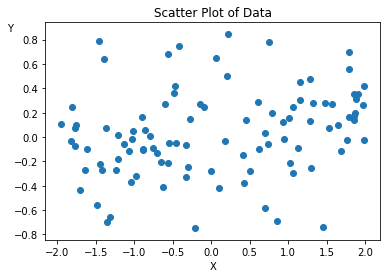

In [18]:
import pickle as pkl
with open ('LinRegData1.pkl', 'rb') as file:
    data = pkl.load(file)

plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('X')
plt.ylabel('Y', y=0.95, rotation = 'horizontal')
plt.title('Scatter Plot of Data')

print('The average x value is: {:.2f}'.format(np.mean(data[:, 0])))
print('The average y value is: {:.2f}'.format(np.mean(data[:, 1])))

print('The standard deviation of x is: {:.2f}'.format(np.std(data[:, 0])))
print('The standard deviation of y is: {:.2f}'.format(np.std(data[:, 1])))

The dataset appears to have no clear relationship between X and Y.

## Fitting A Line

First I fit a line with no intercept to the data. Then, I use the output covariance of the fit to determine the 95% confidence interval in the slope of the fitted line. 


The slope of the fitted line is: [0.07407215]
The 95% confidence interval in the fitted slope of the line is: [[[0.04569533]] , [[0.10244896]]]


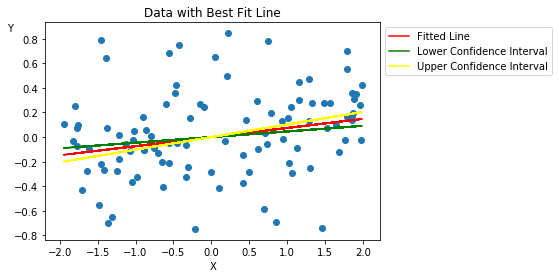

In [58]:
import scipy.optimize 

def func(x, m):
    return m*x

# Fit a line
popt, pcov = scipy.optimize.curve_fit(func, data[:, 0], data[:, 1])

# Confidence interval
lower = popt - np.sqrt(pcov)
upper = popt + np.sqrt(pcov)

# Slope of fitted line
popt_given_data = popt


# Plot
plt.figure()
plt.plot(data[:,0], popt*data[:,0], color = 'red', label = 'Fitted Line')
plt.plot(data[:,0], np.transpose(lower*data[:,0]), color = 'green', label = 'Lower Confidence Interval')
plt.plot(data[:,0], np.transpose(upper*data[:,0]), color = 'yellow', label = 'Upper Confidence Interval')

plt.scatter(data[:, 0], data[:, 1])
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('X')
plt.ylabel('Y', y=0.95, rotation = 'horizontal')
plt.title('Data with Best Fit Line')

print('The slope of the fitted line is: {}'.format(popt))
print('The 95% confidence interval in the fitted slope of the line is: [{} , {}]'.format(lower, upper))



## Best Fit Coefficients of Simulations

In linear regression, we assume that the data are related by a linear model 
$y=βx+e$, where β is the regression coefficient and e is Gaussian noise. By generating many datasets where there is no relationship between X and Y (β = 0) and fitting a line to each simulation, it is possible to estimate the likelihood of seeing the relationship in the original dataset above by chance.

The likelihood of seeing a relationship with slope greater than or equal to the best fit coefficient of the original dataset is 6.60%


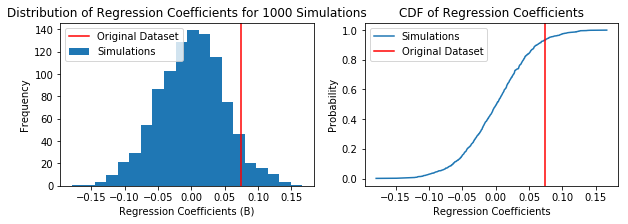

In [45]:
n = 1000 # number simulations
B = np.zeros(n) # regression coefficients

# Fit a line to each simulation
for ii in range(n):
    # Run simulation
    randx = np.random.uniform(-2,2, size = len(data[:, 0]))
    randy = np.random.uniform(-1,1, size = len(data[:, 1]))
    # Fit a line
    popt, pcov = scipy.optimize.curve_fit(func, randx, randy)
    B[ii] = popt

# CDF of regression coefficients
vals, freq = np.unique(B, return_counts = True)
prob = freq/sum(freq)
cdf = np.zeros(len(B))
for ii in range(len(B)):
    if ii == 0:
        cdf[ii] = prob[ii]
    else:
        cdf[ii] = cdf[ii-1] + prob[ii]

# Compare to original dataset        
c = 0
while vals[c] <= popt_given_data:
    c += 1
print('The likelihood of seeing a relationship with slope greater than or equal to the best fit coefficient of the original dataset is {:.2f}%'.format(100-100*cdf[c]))


# Plot distributions
plt.figure(1, figsize = (10, 3))

plt.subplot(121)
plt.hist(B, bins = 20, label = 'Simulations')
plt.axvline(popt_given_data, color = 'red', label = 'Original Dataset')
plt.xlabel('Regression Coefficients (B)')
plt.ylabel('Frequency')
plt.title('Distribution of Regression Coefficients for {} Simulations'.format(n))
plt.legend(loc = 0)

plt.subplot(122)
plt.plot(vals, cdf, label = 'Simulations')
plt.axvline(popt_given_data, color = 'red', label = 'Original Dataset')
plt.xlabel('Regression Coefficients')
plt.ylabel('Probability')
plt.title('CDF of Regression Coefficients')
plt.legend()

## Bootstrapping

Bootstrapping is perhaps a better way to assess confidence in the results above. Below, I resample the original data with replacement to create new datasets, calculate the best fit line for each dataset, and analyze the distribution of regression coeffecients. 


The likelihood of seeing a regression coefficient less than or equal to the best fit coefficient of the original dataset is 48.30%


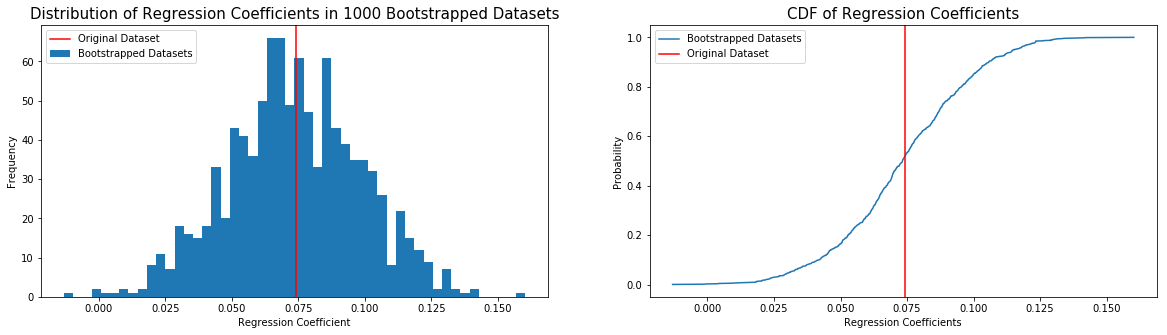

In [52]:
n = 1000 # number of datasets
num = np.shape(data)[0] # number of data points in each dataset
B = np.zeros(n)

for ii in range(n):
    bs = np.zeros(np.shape(data))

    # resample dataset with replacement
    for jj in range(num):
        index = np.random.choice(num, replace = True)
        bs[jj, 0] = data[index, 0]
        bs[jj, 1] = data[index, 1]

    # calculate best fit line for each dataset    
    popt, pcov = scipy.optimize.curve_fit(func, bs[:, 0], bs[:, 1])
    B[ii] = popt

# CDF of regression coefficients
vals, freq = np.unique(B, return_counts = True)
prob = freq/sum(freq)
cdf = np.zeros(len(B))
for ii in range(len(B)):
    if ii == 0:
        cdf[ii] = prob[ii]
    else:
        cdf[ii] = cdf[ii-1] + prob[ii]

c = 0
while vals[c] <= popt_given_data:
    c += 1
print('The likelihood of seeing a regression coefficient less than or equal to the best fit coefficient of the original dataset is {:.2f}%'.format(100-100*cdf[c]))

# Plot
plt.figure(1, figsize = (20, 5))
plt.subplot(121)
plt.hist(B, bins = 50, label = 'Bootstrapped Datasets')
plt.xlabel('Regression Coefficient')
plt.ylabel('Frequency')
plt.axvline(popt_given_data, color = 'red', label = 'Original Dataset')
plt.title('Distribution of Regression Coefficients in {} Bootstrapped Datasets'.format(n), fontsize = 15)
plt.legend(loc = 2)

plt.subplot(122)
plt.plot(vals, cdf, label = 'Bootstrapped Datasets')
plt.axvline(popt_given_data, color = 'red', label = 'Original Dataset')
plt.xlabel('Regression Coefficients')
plt.ylabel('Probability')
plt.title('CDF of Regression Coefficients', fontsize = 15)
plt.legend()

## Comparing Best Fit Lines

The median regression coefficient of all fitted lines from bootstrapping is used to compare to the theoretical best fit line of the original dataset. In order to compare the confidence intervals, the bounds of the best fit lines from bootstrapping are the 2.5th and 97.5th percentiles of the bootstrapped distributions, so that 95% of the regression coefficients fall between these values. 

The median regression coefficient of bootstrapped distribution is 0.0733
The 2.5th percentile is 0.0234
The 97.5th percentile is 0.1219

The slope of the fitted line is: [0.07407215]
The confidence interval in the fitted slope of the line is: [[[0.04569533]], [[0.10244896]]]


Text(0.5, 1.0, 'Comparison of Models')

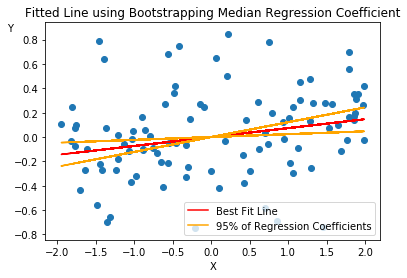

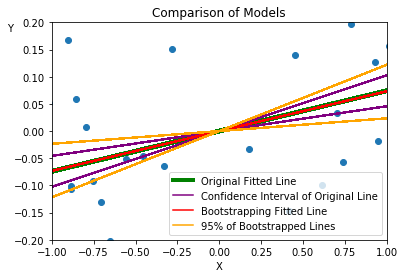

In [89]:
# 2.5th percentile
c = 0
while cdf[c] < 0.025:
    c += 1
lower_perc = vals[c]

# 97.5th percentile
d = 0
while cdf[d] < 0.975:
    d += 1
upper_perc = vals[d]

print('The median regression coefficient of bootstrapped distribution is {:.4f}'.format(np.median(B)))
print('The 2.5th percentile is {:.4f}'.format(lower_perc))
print('The 97.5th percentile is {:.4f}'.format(upper_perc))

print('\nThe slope of the fitted line is: {}'.format(popt_given_data))
print('The confidence interval in the fitted slope of the line is: [{}, {}]'.format(lower, upper))

plt.figure(1)
plt.scatter(data[:,0], data[:,1])
plt.plot(data[:,0], np.median(B)*data[:,0], color = 'red', label = 'Best Fit Line')
plt.plot(data[:,0], lower_perc*data[:,0], color = 'orange', label = '95% of Regression Coefficients')
plt.plot(data[:,0], upper_perc*data[:,0], color = 'orange')
plt.legend(loc = 4)
plt.xlabel('X')
plt.ylabel('Y', y=0.95, rotation = 'horizontal')
plt.title('Fitted Line using Bootstrapping Median Regression Coefficient')

plt.figure(2)
plt.scatter(data[:,0], data[:,1])
plt.plot(data[:,0], popt_given_data*data[:,0], color = 'green', linewidth = 4, label = 'Original Fitted Line')
plt.plot(data[:,0], np.transpose(lower*data[:,0]), color = 'purple', label = 'Confidence Interval of Original Line')
plt.plot(data[:,0], np.transpose(upper*data[:,0]), color = 'purple')
plt.plot(data[:,0], np.median(B)*data[:,0], color = 'red', label = 'Bootstrapping Fitted Line')
plt.plot(data[:,0], lower_perc*data[:,0], color = 'orange', label = '95% of Bootstrapped Lines')
plt.plot(data[:,0], upper_perc*data[:,0], color = 'orange')
plt.legend(loc = 4)
plt.xlim(-1, 1)
plt.ylim(-0.2, 0.2)
plt.xlabel('X')
plt.ylabel('Y', y=0.95, rotation = 'horizontal')
plt.title('Comparison of Models')



## Residuals

The residuals should follow a normal distribution. The Kolmogorov-Smirnov test is used to compare the residuals distribution to a normal distribution.

Text(0.5, 1.0, 'Residuals Distribution')

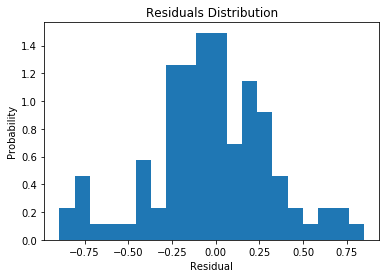

In [90]:
residual = popt_given_data*data[:, 0] - data[:, 1]

plt.figure()
plt.hist(residual, density = True, bins = 20)
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.title('Residuals Distribution')

In [92]:
import scipy.stats as stats

ks_test = stats.kstest(residual, 'norm')
print('The Kolmogorov-Smirnov statistic is: {}'.format(ks_test[0]))
print('The probability of observing residuals is: {}'.format(round(ks_test[1], 10)))



The Kolmogorov-Smirnov statistic is: 0.2681890808086671
The probability of observing residuals is: 7.673e-07


The Kolmogorov-Smirnov statistic suggests that the normal distribution is an 'okay' though not great fit for the residuals. The probability of observing residuals is extremely low, which may explain the deviation from what is expected. 